# Assignment 2 - Abnormality Detection in bone X-Rays
***INSTRUCTOR: PRODROMOS MALAKASIOTIS***

*p3352007 Ilias Giannakos*<br>
*p3352002 Eleni Adamidi*

## Check GPU Runtime is enabled

In [ ]:
!nvidia-smi

Mon Mar 28 18:23:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install keras tuner and ocr package

In [ ]:
!pip install keras-tuner
!pip install keras_ocr

     |████████████████████████████████| 133 kB 5.5 MB/s 
     |████████████████████████████████| 41 kB 326 kB/s 
     |████████████████████████████████| 899 kB 6.7 MB/s 
     |████████████████████████████████| 603 kB 34.4 MB/s 
     |████████████████████████████████| 9.5 MB 32.1 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 


## Imports

In [ ]:
import gc
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sn
import tensorflow as tf
import time
%matplotlib inline
import keras_ocr

from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix


from keras_tuner import HyperParameters, BayesianOptimization
from keras_tuner.engine import trial as trial_module


from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building the model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed #for reproducibility
from tensorflow.keras.preprocessing.image import ImageDataGenerator #to load the images while training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
import zipfile

log = logging.getLogger('tensorflow')
log.setLevel(logging.ERROR)

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


## Get the MURA-v1.1 dataset

In [ ]:
!wget 'https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip'

--2022-03-28 18:24:05--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip       100%[===================>]   3.15G  14.9MB/s    in 3m 49s  

2022-03-28 18:27:55 (14.1 MB/s) - ‘MURA-v1.1.zip’ saved [3380245855/3380245855]



In [ ]:
with zipfile.ZipFile('MURA-v1.1.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
DATASET_PATH = 'MURA-v1.1'

## Load the dataset
Here we created a helping function to load the dataset, since all information is in the filename column. We extract the type of the X-ray, the patientId, the study of each X-ray, then we calculate the column patient_study_type as the concat of the 3 above, since abnormality is classified per patient, study and type and finally we extract the abnormality and assign 0 to negative and 1 to positive class

In [ ]:
def generate_df(csv_name):
    df = pd.read_csv(csv_name, header=None, names=['path'])
    df['type'] = (df.path.str.split('/')).str[2]
    df['patient'] = (df.path.str.split('/')).str[3]
    df['study'] = (df.path.str.extract('(study.*)_'))
    df['patient_study_type'] = df['patient'] + '_' + df['study'] + '_' + df['type']
    df['class'] = (df.path.str.extract('study.*_(positive|negative)'))
    df['class'] = df['class'].replace({'negative': 0, 'positive':1})
    return df

This is what our dataset looks like.

In [ ]:
train_df_orig = generate_df(os.path.join(DATASET_PATH, 'train_image_paths.csv'))
train_df_orig

,path,type,patient,study,patient_study_type,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,patient00001,study1,patient00001_study1_XR_SHOULDER,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,patient00001,study1,patient00001_study1_XR_SHOULDER,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER,patient00001,study1,patient00001_study1_XR_SHOULDER,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,patient00002,study1,patient00002_study1_XR_SHOULDER,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER,patient00002,study1,patient00002_study1_XR_SHOULDER,1
...,...,...,...,...,...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,XR_HAND,patient11183,study1,patient11183_study1_XR_HAND,0
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,XR_HAND,patient11183,study1,patient11183_study1_XR_HAND,0
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,XR_HAND,patient11184,study1,patient11184_study1_XR_HAND,0
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,XR_HAND,patient11184,study1,patient11184_study1_XR_HAND,0


In [ ]:
test_df = generate_df(os.path.join(DATASET_PATH, 'valid_image_paths.csv'))
test_df

,path,type,patient,study,patient_study_type,class
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,XR_WRIST,patient11186,study1,patient11186_study1_XR_WRIST,1
...,...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0


##Data Visualization & Preprocess of the dataset (preprocess of images not done due to time issues)

We have observed that the images in the dataset contain text / digits, which is ultimately unnecessary information for our model. We wanted to process every image and clear out the text, as to have more quality pictures. Below is an example of the preprocessing and the full code, yet due to Google Colab runtime restrictions we were not able to train our model with the processed images.

In [ ]:
#https://towardsdatascience.com/remove-text-from-images-using-cv2-and-keras-ocr-24e7612ae4f4

def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)
    
pipeline = keras_ocr.pipeline.Pipeline()
def inpaint_text(img_path, pipeline):
    # read image
    img = keras_ocr.tools.read(img_path)
    # generate (word, box) tuples 
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(np.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                 
    return(img)

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


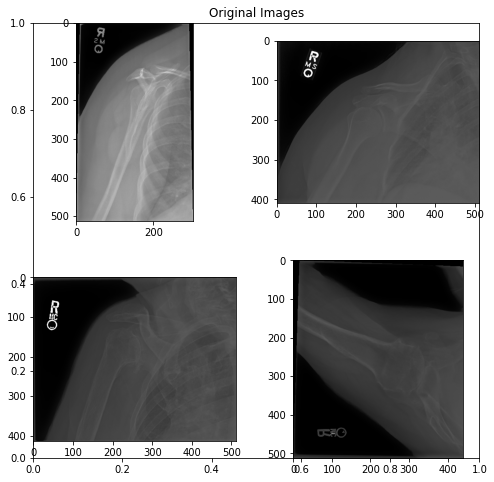

In [ ]:
w = 10
h = 10
columns = 2
rows = 2

fig = plt.figure(figsize=(8, 8))
plt.title("Original Images")
for i in range(1, columns*rows +1):
    img = keras_ocr.tools.read(train_df_orig.path[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

plt.show()

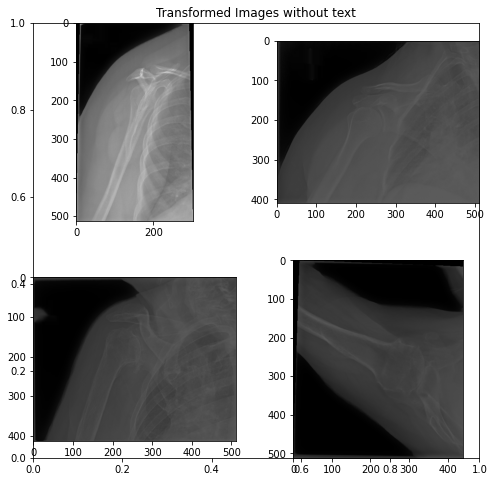

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.title("Transformed Images without text")
for i in range(1, columns*rows +1):
    img = inpaint_text(train_df_orig.path[i], pipeline)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

plt.show()

In [ ]:
def generate_cleaned_image(path):
  new_path = path.replace("MURA-v1.1","MURA_AUG")
  path_stripped, img_name = new_path.split("/")[:-1], new_path.split("/")[-1]
  path_stripped = "/".join(path_stripped)
  path_exists = os.path.exists(path_stripped)
  if not path_exists:
    os.makedirs(path_stripped)
  augmented_img = inpaint_text(path, pipeline)
  img = Image.fromarray(augmented_img, 'RGB')
  img.save(path_stripped+"/"+img_name)
  return None



In [ ]:
#did not run due to time issues, but this would generate a new folder named MURA_AUG with the processed images and then we would use this as our training dataset
!mkdir "MURA_AUG"
all_images = train_df_orig.path.values.tolist()

for image in all_images: 
  generate_cleaned_image(image)

Here we make some quick statistics. We see that for each type, of X-ray, how many X-rays we have, and how many of them belong to class 1.

In [ ]:
train_df_orig.groupby(['type']).agg({'path': 'count', 'class': 'sum'}).rename(columns={"class":"positives"})

,path,positives
type,,
XR_ELBOW,4931,2006
XR_FINGER,5106,1968
XR_FOREARM,1825,661
XR_HAND,5543,1484
XR_HUMERUS,1272,599
XR_SHOULDER,8379,4168
XR_WRIST,9752,3987


Then we split our train dataset into train and validation set, keeping 90% for training and 10% for validation, with respect to the type and class. We use stratified version because we would want the model to train on equal propertion of x-ray type and class.

In [ ]:
train_df, val_df = train_test_split(train_df_orig, stratify=train_df_orig[['type', 'class']], test_size=0.1)

Here, we see the final train, validation and test set that are going to be used.

In [ ]:
train_df.reset_index(inplace=True, drop=True)
train_df

,path,type,patient,study,patient_study_type,class
0,MURA-v1.1/train/XR_ELBOW/patient05205/study1_p...,XR_ELBOW,patient05205,study1,patient05205_study1_XR_ELBOW,1
1,MURA-v1.1/train/XR_ELBOW/patient05567/study1_n...,XR_ELBOW,patient05567,study1,patient05567_study1_XR_ELBOW,0
2,MURA-v1.1/train/XR_WRIST/patient06757/study1_p...,XR_WRIST,patient06757,study1,patient06757_study1_XR_WRIST,1
3,MURA-v1.1/train/XR_SHOULDER/patient01992/study...,XR_SHOULDER,patient01992,study1,patient01992_study1_XR_SHOULDER,0
4,MURA-v1.1/train/XR_SHOULDER/patient02166/study...,XR_SHOULDER,patient02166,study1,patient02166_study1_XR_SHOULDER,0
...,...,...,...,...,...,...
33122,MURA-v1.1/train/XR_WRIST/patient07158/study1_p...,XR_WRIST,patient07158,study1,patient07158_study1_XR_WRIST,1
33123,MURA-v1.1/train/XR_HAND/patient10302/study1_ne...,XR_HAND,patient10302,study1,patient10302_study1_XR_HAND,0
33124,MURA-v1.1/train/XR_FOREARM/patient06238/study1...,XR_FOREARM,patient06238,study1,patient06238_study1_XR_FOREARM,0
33125,MURA-v1.1/train/XR_FINGER/patient03621/study1_...,XR_FINGER,patient03621,study1,patient03621_study1_XR_FINGER,1


In [ ]:
val_df.reset_index(inplace=True, drop=True)
val_df

,path,type,patient,study,patient_study_type,class
0,MURA-v1.1/train/XR_SHOULDER/patient00146/study...,XR_SHOULDER,patient00146,study1,patient00146_study1_XR_SHOULDER,1
1,MURA-v1.1/train/XR_WRIST/patient07489/study1_n...,XR_WRIST,patient07489,study1,patient07489_study1_XR_WRIST,0
2,MURA-v1.1/train/XR_FINGER/patient04831/study1_...,XR_FINGER,patient04831,study1,patient04831_study1_XR_FINGER,0
3,MURA-v1.1/train/XR_SHOULDER/patient00350/study...,XR_SHOULDER,patient00350,study1,patient00350_study1_XR_SHOULDER,1
4,MURA-v1.1/train/XR_SHOULDER/patient00723/study...,XR_SHOULDER,patient00723,study1,patient00723_study1_XR_SHOULDER,1
...,...,...,...,...,...,...
3676,MURA-v1.1/train/XR_SHOULDER/patient01855/study...,XR_SHOULDER,patient01855,study1,patient01855_study1_XR_SHOULDER,0
3677,MURA-v1.1/train/XR_SHOULDER/patient02646/study...,XR_SHOULDER,patient02646,study1,patient02646_study1_XR_SHOULDER,0
3678,MURA-v1.1/train/XR_ELBOW/patient05539/study1_n...,XR_ELBOW,patient05539,study1,patient05539_study1_XR_ELBOW,0
3679,MURA-v1.1/train/XR_ELBOW/patient05640/study2_n...,XR_ELBOW,patient05640,study2,patient05640_study2_XR_ELBOW,0


In [ ]:
test_df = generate_df(os.path.join(DATASET_PATH, 'valid_image_paths.csv'))
test_df

,path,type,patient,study,patient_study_type,class
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,XR_WRIST,patient11186,study1,patient11186_study1_XR_WRIST,1
...,...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0


## Image Data Generation creation
In order to load the images at our disposal to any neural network, we utilize the Image Data Generation class from keras. These objects only load the current batches images that are needed during training, which help us not overload the ram.
For the train dataset we created two generators. One that takes the images as they are in the dataset and one that flips a sample of the batch either horizontal or vertical, or rotates it by 5 degrees. Also, both of these generators don't take the images by the order they are on the dataset but they shuffle them.

In [ ]:
datagen = ImageDataGenerator(rescale=1./255) 


Here we set the parameters for our models.


1.   `batch_size` We set it to the default value which is **32**
2.   `epochs_upper` The number of epochs for the upper part of the pretrained model will fit with the pretrained weights frozen
3.   `epochs` The number of epochs that our models will run.
4.   `epochs_trial` The number of epochs that the models will run while searching for the best hyperparameters. Since the resources where limited, we just set this to **4**. If we had more time for training, we would have a very big number until the model converges.
5.   `trials` The number of trials that our tuner will search for hyperparameters. Again if we had more time, this number would be set to **20**
6.   `IMG_HEIGHT` The height of the image
7.   `IMG_WIDTH` The width of the image



In [ ]:
batch_size = 32
epochs_upper = 4
epochs = 8
epochs_trial = 4
trials = 4
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
train_data_gen = datagen.flow_from_dataframe(train_df,
                                             x_col='path',
                                             y_col='class',
                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                             color_mode='rgb',
                                             class_mode='raw',
                                             batch_size=batch_size,
                                             shuffle=True)

Found 33127 validated image filenames.


In [ ]:
train_data_gen_aug = datagen.flow_from_dataframe(train_df,
                                             rotation_range=5,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             x_col='path',
                                             y_col='class',
                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                             color_mode='rgb',
                                             class_mode='raw',
                                             batch_size=batch_size,
                                             shuffle=True)

Found 33127 validated image filenames.


In [ ]:
val_data_gen = datagen.flow_from_dataframe(val_df,
                                           x_col='path',
                                           y_col='class',
                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                           color_mode='rgb',
                                           class_mode='raw',
                                           batch_size=batch_size,
                                           shuffle=False)

Found 3681 validated image filenames.


In [ ]:
test_data_gen = datagen.flow_from_dataframe(test_df,
                                            x_col='path',
                                            y_col='class',
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode='rgb',
                                            class_mode='raw',
                                            batch_size=batch_size,
                                            shuffle=False)

Found 3197 validated image filenames.


## Models Creation, Tuning & Training

Here we override the ReturnBestEarlyStopping so as to return the weights from the best epoch

In [ ]:
class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

For the CNN model we created the `build_cnn_model` that creates and returns the model based on the hyperparameters we pass. This is the CNN presented in class, with the only difference that now that we have bigger images, thus created bigger filters. Also, since now the problem is to classify an image between two classes, the output layer is now a Dense of one unit, and the activation function being a sigmoid, so as to get the probabily of the possitive class 

In [ ]:
def build_cnn_model(hp):
    
    # Define the input layer.
    inputs = Input(
        shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        name='Input'
    )

    x = inputs
    # Define the convolutional layers.
    for i in range(hp['conv_layers']):
        x = Conv2D(
            filters=32*(2**i),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation='relu',
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if hp['dropout_rate'] > 0:
          x = Dropout(
              rate=hp['dropout_rate'],
              name='Dropout-{0:d}'.format(i + 1)
          )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Define the output layer.
    outputs = Dense(
        units=1,
        activation='sigmoid',
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary() # Print a description of the model.
    return model

Since we have a small number of trials, we give the tuner only 2 possible values for the convolutional layers and 2 possible values for the dropout rate. Given more time, it would be worth to search the dropout rate in range of [0, 0.5] and the layers from 2 to 5. After the trials are complete we return the best hyperparameters

In [ ]:
tunable_parameters = {
    'conv_layers': [4, 5],
    'dropout_rate': [0.3, 0.2]
    }

hp = HyperParameters()
for parameter_name, parameter_value in tunable_parameters.items():
    hp.Choice(parameter_name, parameter_value)

tuner = BayesianOptimization(
        hypermodel=build_cnn_model,
        hyperparameters=hp,
        objective='val_accuracy',
        max_trials=trials,
        overwrite=True
        )

early_stopping = ReturnBestEarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
        )
    
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    cooldown=2,
    verbose=1
    )

tuner.search_space_summary()
tuner.search(
    train_data_gen,
    validation_data=val_data_gen,
    verbose=1,
    epochs=epochs_trial,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
    )

print('Tuning results')
tuner.results_summary()
best_params_cnn = tuner.get_best_hyperparameters(num_trials=1)[0].values
best_model_cnn = tuner.get_best_models(num_models=1)[0]

Trial 4 Complete [00h 12m 53s]
val_accuracy: 0.6232002377510071

Best val_accuracy So Far: 0.6799782514572144
Total elapsed time: 00h 52m 05s
Tuning results
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_layers: 5
dropout_rate: 0.2
Score: 0.6799782514572144
Trial summary
Hyperparameters:
conv_layers: 4
dropout_rate: 0.2
Score: 0.6715566515922546
Trial summary
Hyperparameters:
conv_layers: 5
dropout_rate: 0.3
Score: 0.631893515586853
Trial summary
Hyperparameters:
conv_layers: 5
dropout_rate: 0.2
Score: 0.6232002377510071
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 224, 224, 32)      896       
                      

Having found our best hyperparameters, now we create a CNN model with those hyperparameters and train it with a larger number of epochs.

In [ ]:
best_cnn_model = build_cnn_model(best_params_cnn)

cnn_hs = best_cnn_model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    verbose=1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 112, 112, 32)      0         
                                                                 
 Dropout-1 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 MaxPool2D-2 (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 Dropout-2 (Dropout)         (None, 56, 56, 64)        0   

Then we train a second CNN with the same hyperparameters, with the only difference being that we give the augmented generator as our train data.

In [ ]:
best_cnn_model_aug = build_cnn_model(best_params_cnn)

cnn_hs_aug = best_cnn_model_aug.fit(
    train_data_gen_aug,
    validation_data=val_data_gen,
    verbose=1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 112, 112, 32)      0         
                                                                 
 Dropout-1 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 MaxPool2D-2 (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 Dropout-2 (Dropout)         (None, 56, 56, 64)        0   

For the resnet model, as it was much more time consuming to search for hyperparameters.

In [ ]:
def build_resnet_model():

    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='max',
    )

    x = base_model.output
    # Define 3 extra hidden layers on top of resnet
    for i in range(3):
        x = Dense(
            units=512,
            kernel_initializer='glorot_uniform',
            activation='relu',
        )(x)
        x = Dropout(rate=0.2)(x)
        
    # Define the output layer.
    output = Dense(
        units=1,
        activation='sigmoid',
        name='Output'
    )(x)

    # Define the model.
    model = Model(inputs=base_model.input, outputs=output)
    
    return base_model, model

In [ ]:
resnet_base_model, resnet_full_model = build_resnet_model()

early_stopping = ReturnBestEarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
        )
    
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    cooldown=2,
    verbose=1
    )

# First we train only the upper layers for a few epochs in order to optimize our "new" layers
resnet_base_model.trainable = False

resnet_full_model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

hs_upper_layers = resnet_full_model.fit(
    train_data_gen,
    steps_per_epoch=len(train_data_gen),
    epochs=epochs_upper,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print('Finished training upper layers.')


resnet_base_model.trainable = True

#we now train the whole model (including the lower layers) but with very small LR.
resnet_full_model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

hs_full_model_resnet = resnet_full_model.fit(
    train_data_gen,
    steps_per_epoch=len(train_data_gen),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)



Epoch 1/4
1036/1036 [==============================] - 253s 240ms/step - loss: 0.6818 - accuracy: 0.5883 - val_loss: 0.6635 - val_accuracy: 0.5971 - lr: 0.0010
Epoch 2/4
1036/1036 [==============================] - 246s 238ms/step - loss: 0.6688 - accuracy: 0.5982 - val_loss: 0.6615 - val_accuracy: 0.5977 - lr: 0.0010
Epoch 3/4
1036/1036 [==============================] - 246s 238ms/step - loss: 0.6658 - accuracy: 0.5972 - val_loss: 0.6617 - val_accuracy: 0.5958 - lr: 0.0010
Epoch 4/4
1036/1036 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.5972
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1036/1036 [==============================] - 246s 238ms/step - loss: 0.6646 - accuracy: 0.5972 - val_loss: 0.6622 - val_accuracy: 0.5968 - lr: 0.0010
Restoring model weights from the end of the best epoch.
Finished training upper layers.
Epoch 1/8
1036/1036 [==============================] - 736s 703ms/step - loss: 0.7879 - accuracy: 0.6390 - v

In [ ]:
resnet_base_model_aug, resnet_full_model_aug = build_resnet_model()

early_stopping = ReturnBestEarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
        )
    
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    cooldown=2,
    verbose=1
    )

# First we train only the upper layers for a few epochs in order to optimize our "new" layers
resnet_base_model_aug.trainable = False

resnet_full_model_aug.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

hs_upper_layers = resnet_full_model_aug.fit(
    train_data_gen_aug,
    steps_per_epoch=len(train_data_gen_aug),
    epochs=epochs_upper,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print('Finished training upper layers.')


resnet_base_model_aug.trainable = True

#we now train the whole model (including the lower layers) but with very small LR.
resnet_full_model_aug.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

hs_full_model_resnet = resnet_full_model_aug.fit(
    train_data_gen_aug,
    steps_per_epoch=len(train_data_gen_aug),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

94781440/94765736 [==============================] - 3s 0us/step
Epoch 1/4
1036/1036 [==============================] - 258s 242ms/step - loss: 0.6875 - accuracy: 0.5887 - val_loss: 0.6738 - val_accuracy: 0.5958 - lr: 0.0010
Epoch 2/4
1036/1036 [==============================] - 248s 239ms/step - loss: 0.6725 - accuracy: 0.5960 - val_loss: 0.6719 - val_accuracy: 0.5958 - lr: 0.0010
Epoch 3/4
1036/1036 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.5953
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1036/1036 [==============================] - 247s 238ms/step - loss: 0.6696 - accuracy: 0.5953 - val_loss: 0.6709 - val_accuracy: 0.5958 - lr: 0.0010
Epoch 4/4
1036/1036 [==============================] - 246s 238ms/step - loss: 0.6652 - accuracy: 0.5959 - val_loss: 0.6625 - val_accuracy: 0.5958 - lr: 1.0000e-04
Restoring model weights from the end of the best epoch.
Finished training upper layers.
Epoch 1/8
1036/1036 [==================

In [ ]:
# we have saved our models on google drive for reproducibility
#from google.colab import drive
#drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# best_cnn_model = keras.models.load_model("drive/MyDrive/Models/cnn_model_1")
# best_cnn_model_aug = keras.models.load_model("drive/MyDrive/Models/cnn_model_augmented")
# resnet_full_model = keras.models.load_model("drive/MyDrive/Models/resnet_original")
# resnet_full_model_aug = keras.models.load_model("drive/MyDrive/Models/resnet_augmented")

## Models Evaluation
Having trained all our models, now is the time to evaluate them. In order to do that we get the predictions for both validation and test set for each model and we store them in a new validation and test dataframe along with the actual classes.

In [ ]:
print("Evaluate CNN's without augmentation on test data")
results_cnn = best_cnn_model.evaluate(test_data_gen, batch_size=32)
print("test loss, test acc:", results_cnn)

print("Evaluate CNN's with augmnentation on test data")
results_cnn_aug = best_cnn_model_aug.evaluate(test_data_gen, batch_size=32)
print("test loss, test acc:", results_cnn_aug)


Evaluate CNN's without augmentation on test data
100/100 [==============================] - 21s 191ms/step - loss: 0.6124 - accuracy: 0.6662
test loss, test acc: [0.6123952865600586, 0.6662496328353882]
Evaluate CNN's with augmnentation on test data
100/100 [==============================] - 15s 152ms/step - loss: 0.6016 - accuracy: 0.6781
test loss, test acc: [0.6016333103179932, 0.6781357526779175]


In [ ]:
print("Evaluate Resnet without augmentation model on test data")
results_resnet = resnet_full_model.evaluate(test_data_gen, batch_size=32)
print("test loss, test acc:", results_resnet)

print("Evaluate Resnet with augmnentation model on test data")
results_resnet_aug = resnet_full_model_aug.evaluate(test_data_gen, batch_size=32)
print("test loss, test acc:", results_resnet_aug)

Evaluate Resnet without augmentation model on test data
100/100 [==============================] - 32s 294ms/step - loss: 0.5264 - accuracy: 0.7601
test loss, test acc: [0.5263919830322266, 0.7600876092910767]
Evaluate Resnet with augmnentation model on test data
100/100 [==============================] - 29s 277ms/step - loss: 0.9404 - accuracy: 0.7720
test loss, test acc: [0.940420925617218, 0.771973729133606]


We observe that in both cases, the model that was trained with augmented data have better performance to the one trained with original ones.
Therefore we will discard the non augmented models and continue reporting with the 2 augmented ones.

In [ ]:
val_predictions_cnn_aug = best_cnn_model_aug.predict(val_data_gen)
test_predictions_cnn_aug = best_cnn_model_aug.predict(test_data_gen)

In [ ]:
val_predictions_resnet_aug = resnet_full_model_aug.predict(val_data_gen)
test_predictions_resnet_aug = resnet_full_model_aug.predict(test_data_gen)

In [ ]:
#constructing a df with all the predictions
val_df['pred_cnn_aug_raw'] = val_predictions_cnn_aug
val_df['pred_resnet_aug_raw'] =val_predictions_resnet_aug
val_df

,path,type,patient,study,patient_study_type,class,pred_cnn_aug_raw,pred_resnet_aug_raw
0,MURA-v1.1/train/XR_WRIST/patient06888/study1_p...,XR_WRIST,patient06888,study1,patient06888_study1_XR_WRIST,1,0.525225,0.999114
1,MURA-v1.1/train/XR_WRIST/patient06554/study1_p...,XR_WRIST,patient06554,study1,patient06554_study1_XR_WRIST,1,0.599125,0.998462
2,MURA-v1.1/train/XR_SHOULDER/patient01058/study...,XR_SHOULDER,patient01058,study1,patient01058_study1_XR_SHOULDER,1,0.403676,0.979135
3,MURA-v1.1/train/XR_SHOULDER/patient00775/study...,XR_SHOULDER,patient00775,study1,patient00775_study1_XR_SHOULDER,1,0.642015,0.999844
4,MURA-v1.1/train/XR_HAND/patient10515/study1_ne...,XR_HAND,patient10515,study1,patient10515_study1_XR_HAND,0,0.193142,0.000757
...,...,...,...,...,...,...,...,...
3676,MURA-v1.1/train/XR_HAND/patient10737/study1_ne...,XR_HAND,patient10737,study1,patient10737_study1_XR_HAND,0,0.127165,0.012956
3677,MURA-v1.1/train/XR_WRIST/patient07510/study1_n...,XR_WRIST,patient07510,study1,patient07510_study1_XR_WRIST,0,0.095727,0.000138
3678,MURA-v1.1/train/XR_HAND/patient10126/study1_po...,XR_HAND,patient10126,study1,patient10126_study1_XR_HAND,1,0.216595,0.998951
3679,MURA-v1.1/train/XR_WRIST/patient08449/study1_n...,XR_WRIST,patient08449,study1,patient08449_study1_XR_WRIST,0,0.456969,0.004276


In [ ]:
val_df['pred_cnn_aug'] = val_df['pred_cnn_aug_raw'].apply(lambda x: 1 if x>0.5 else 0)
val_df['pred_resnet_aug'] =val_df['pred_cnn_aug_raw'].apply(lambda x: 1 if x>0.5 else 0)
val_df

,path,type,patient,study,patient_study_type,class,pred_cnn_aug_raw,pred_resnet_aug_raw,pred_cnn_aug,pred_resnet_aug
0,MURA-v1.1/train/XR_WRIST/patient06888/study1_p...,XR_WRIST,patient06888,study1,patient06888_study1_XR_WRIST,1,0.525225,0.999114,1,1
1,MURA-v1.1/train/XR_WRIST/patient06554/study1_p...,XR_WRIST,patient06554,study1,patient06554_study1_XR_WRIST,1,0.599125,0.998462,1,1
2,MURA-v1.1/train/XR_SHOULDER/patient01058/study...,XR_SHOULDER,patient01058,study1,patient01058_study1_XR_SHOULDER,1,0.403676,0.979135,0,0
3,MURA-v1.1/train/XR_SHOULDER/patient00775/study...,XR_SHOULDER,patient00775,study1,patient00775_study1_XR_SHOULDER,1,0.642015,0.999844,1,1
4,MURA-v1.1/train/XR_HAND/patient10515/study1_ne...,XR_HAND,patient10515,study1,patient10515_study1_XR_HAND,0,0.193142,0.000757,0,0
...,...,...,...,...,...,...,...,...,...,...
3676,MURA-v1.1/train/XR_HAND/patient10737/study1_ne...,XR_HAND,patient10737,study1,patient10737_study1_XR_HAND,0,0.127165,0.012956,0,0
3677,MURA-v1.1/train/XR_WRIST/patient07510/study1_n...,XR_WRIST,patient07510,study1,patient07510_study1_XR_WRIST,0,0.095727,0.000138,0,0
3678,MURA-v1.1/train/XR_HAND/patient10126/study1_po...,XR_HAND,patient10126,study1,patient10126_study1_XR_HAND,1,0.216595,0.998951,0,0
3679,MURA-v1.1/train/XR_WRIST/patient08449/study1_n...,XR_WRIST,patient08449,study1,patient08449_study1_XR_WRIST,0,0.456969,0.004276,0,0


In [ ]:
#constructing a df with all the predictions
test_df['pred_cnn_aug_raw'] = test_predictions_cnn_aug
test_df['pred_resnet_aug_raw'] =test_predictions_resnet_aug
test_df

,path,type,patient,study,patient_study_type,class,pred_cnn_aug_raw,pred_resnet_aug_raw
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.481910,0.998062
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.483434,0.985017
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.352370,0.975148
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.342699,0.910970
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,XR_WRIST,patient11186,study1,patient11186_study1_XR_WRIST,1,0.291970,0.983592
...,...,...,...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0,0.080908,0.000050
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0,0.151170,0.000015
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0,0.107057,0.108042
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0,0.220589,0.004874


In [ ]:
#constructing a df with all the predictions
test_df['pred_cnn_aug'] = test_df['pred_cnn_aug_raw'].apply(lambda x: 1 if x>0.5 else 0)
test_df['pred_resnet_aug'] =test_df['pred_resnet_aug_raw'].apply(lambda x: 1 if x>0.5 else 0)
test_df

,path,type,patient,study,patient_study_type,class,pred_cnn_aug_raw,pred_resnet_aug_raw,pred_cnn_aug,pred_resnet_aug
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.481910,0.998062,0,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.483434,0.985017,0,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.352370,0.975148,0,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,XR_WRIST,patient11185,study1,patient11185_study1_XR_WRIST,1,0.342699,0.910970,0,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,XR_WRIST,patient11186,study1,patient11186_study1_XR_WRIST,1,0.291970,0.983592,0,1
...,...,...,...,...,...,...,...,...,...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0,0.080908,0.000050,0,0
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,XR_FINGER,patient11967,study1,patient11967_study1_XR_FINGER,0,0.151170,0.000015,0,0
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0,0.107057,0.108042,0,0
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,XR_FINGER,patient11738,study1,patient11738_study1_XR_FINGER,0,0.220589,0.004874,0,0


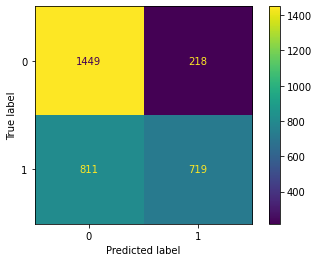

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_df["class"], test_df.pred_cnn_aug)

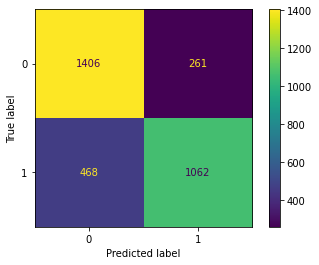

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_df["class"], test_df.pred_resnet_aug)

In [ ]:
print("Classification report for CNN model")
print(classification_report(test_df["class"], test_df.pred_cnn_aug))

Classification report for CNN model
              precision    recall  f1-score   support

           0       0.64      0.87      0.74      1667
           1       0.77      0.47      0.58      1530

    accuracy                           0.68      3197
   macro avg       0.70      0.67      0.66      3197
weighted avg       0.70      0.68      0.66      3197



In [ ]:
print("Classification report for Resnet model")
print(classification_report(test_df["class"], test_df.pred_resnet_aug))

Classification report for Resnet model
              precision    recall  f1-score   support

           0       0.75      0.84      0.79      1667
           1       0.80      0.69      0.74      1530

    accuracy                           0.77      3197
   macro avg       0.78      0.77      0.77      3197
weighted avg       0.78      0.77      0.77      3197



In [ ]:
xray_types = test_df["type"].unique().tolist()

Confusion matrix for XR_WRIST:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       364
           1       0.81      0.72      0.76       295

    accuracy                           0.80       659
   macro avg       0.80      0.79      0.80       659
weighted avg       0.80      0.80      0.80       659

Confusion matrix for XR_FOREARM:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       150
           1       0.89      0.65      0.75       151

    accuracy                           0.78       301
   macro avg       0.81      0.78      0.78       301
weighted avg       0.81      0.78      0.78       301

Confusion matrix for XR_HAND:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       271
           1       0.78      0.58      0.66       189

    accuracy                           0.76       460
   macro avg       0.77      0.73 

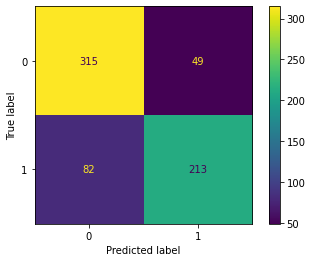

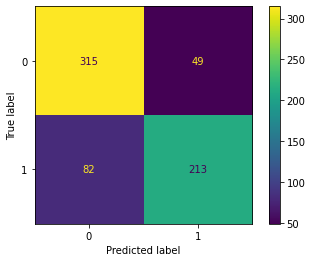

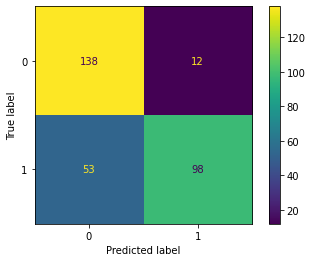

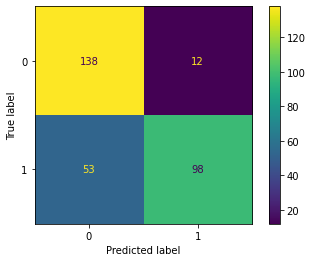

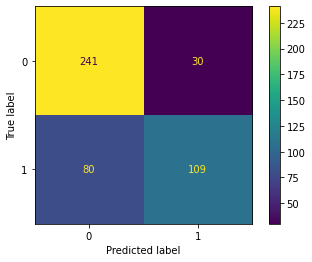

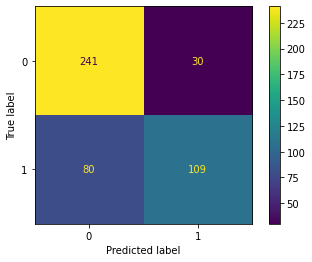

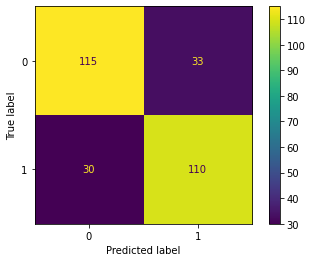

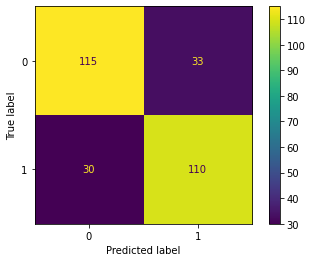

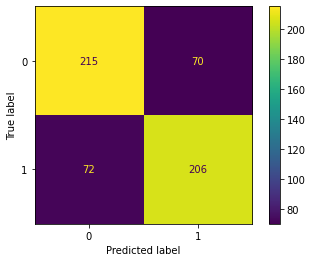

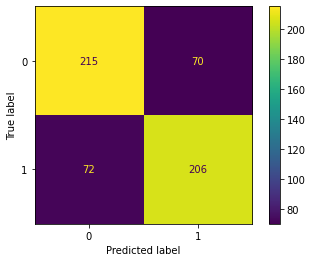

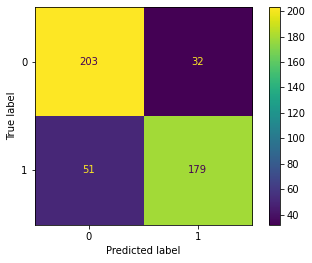

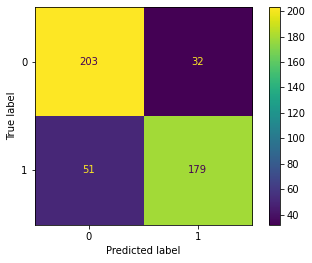

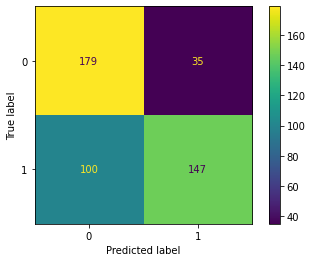

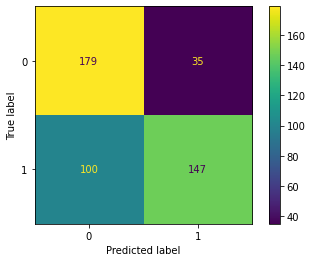

In [ ]:
#due to rendering issues the confusion matrices plots are being generated on the bottom of the cell, even though they should appear just before the classification report
for xray_type in xray_types:
   copied_df = test_df[test_df["type"]== xray_type]
   print("Confusion matrix for {}:".format(xray_type), end="\n")
   matrix = ConfusionMatrixDisplay.from_predictions(copied_df["class"], copied_df.pred_resnet_aug)
   report = classification_report(copied_df["class"],copied_df.pred_resnet_aug)
   print(report)

